# Women on Board

### Exploring the Influence of Gender Diversity: Does C25 Stock Performance Correlate with Female Representation on Boards of Directors?

#### I examine the potential connection between the presence of women on boards of directors and the performance metrics of stocks in the C25 index, investigating whether gender diversity plays a role in financial outcomes such as returns and volatility.

To conduct the analysis, I utilize data from finans.dk on the percentage of women on boards in C25 stocks, retrieved on 30 of March, 2023. Additionally, I download data for the stocks and the C25 index using Yahoo Finance.

I explore the datasets by plotting the returns of each stock compared to the C25, visualizing the proportion of women on boards for each company, and comparing the expected return of each stock on the C25 index to the amount of women on boards. Notably, the plot does not seem to yield any correlation between expected returns and the number of women on boards.

Finally, I create a new portfolio weighted by the number of women on boards, assuming that the composition has remained consistent for the past five years. Comparing the new portfolio to the C25 index, I find that weighting the index by women on boards does not underperform compared to the market.

While this is not conclusive evidence that women on boards improve performance, as numerous portfolios could be created from the C25 index, it does not suggest that having women on boards is a detrimental strategy.

To run this notebook you have to install yfinance and adjustText.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from matplotlib_venn import venn2
from datetime import datetime

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

# install yfinance
#%pip install yfinance

import yfinance as yf

# install adjustText
#%pip install adjustText

from adjustText import adjust_text

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 12})

# Reading and Cleaning Data

I import a CSV file that includes the companies in the C25 index, a yfinance ticker, and the percentage of female board members for each company.

In [2]:
# read file, sort values descending and reset index
C25F = (pd.read_csv('C25F.csv')
        .sort_values(by =['femaleboard'], ascending=False)
        .reset_index(drop=True))

# display data
#C25F.head()

I generate a list of yfinance tickers to pass as input to yfinance.

In [3]:
# generate a list of yfinance tickers
C25_tickers = list(C25F['yfinanceticker'])

I download historical prices adjusted for dividends, stock splits and offerings from yfinance.

In [4]:
# get historical market data
hist_p = yf.download(tickers = C25_tickers, start = '2020-03-01',
                        end = '2023-04-01',
                        interval = '1mo')

# get adjusted close for each stock and change dates
hist_p = hist_p['Adj Close']

# change dates
hist_p.index = hist_p.index.strftime("%m-%y")

# display dataframe
#hist_p.head()


[*********************100%***********************]  26 of 26 completed


In [5]:
# calculate monthly returns and cumulative returns 
hist_mr, hist_cr = dp.calculate_returns(hist_p)

# set the first row of the cumulative returns to 1
hist_cr.iloc[0] = 1

# display dataframe
#hist_cr.head()

## Exploring the Data

To explore the data, I first visualize the cumulative returns of each stock relative to the C25 index.
<br>
Next, I present a bar chart which show the proportion of female board members on each company.

In [6]:
# define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options=C25_tickers, description='Stock:')


# display the interactive plot using widgets interact
widgets.interact(dp.cum_ret_plot, data=widgets.fixed(hist_cr), stock=stockpicker,
                # set reference
                ref = widgets.fixed('^OMXC25'),
                # set figure no.
                fig = widgets.fixed(1),
                # ax_data are only for non-interactive plots
                ax_data=widgets.fixed(None));

interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

Figure 1 illustrates the cumulative return from investing 1 kr in a stock within the C25 index as opposed to investing in the index itself.





C:\Users\jonas\AppData\Local\Temp\ipykernel_15072\2463232299.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10.5)


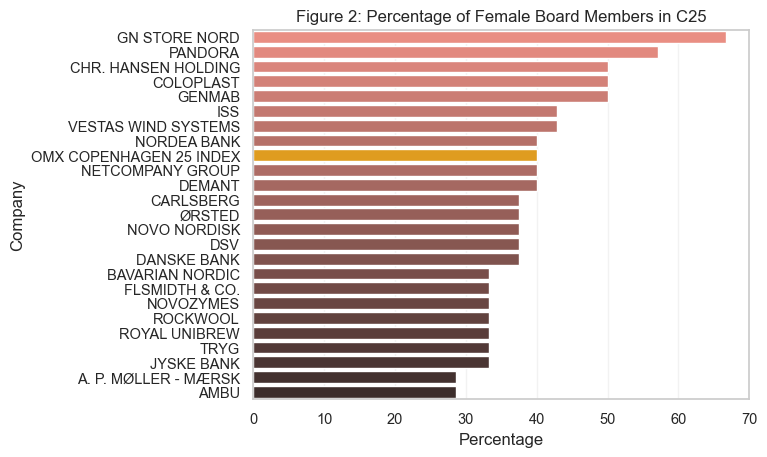

In [7]:
# set theme
sns.set(style="whitegrid")

# create a list with n colors of dark:salmon_r
palette = list(sns.color_palette('dark:salmon_r', n_colors = len(C25F)))

# insert the color 'orange' in the list of colors using the index of C25
palette.insert(C25F[C25F['company'] == 'OMX COPENHAGEN 25 INDEX'].index[0], 'orange')

# create the bar chart with the custom palette
ax = sns.barplot(x='femaleboard', y='company', data=C25F, palette=palette) 

# set the title, labels and ticks
ax.set_title('Figure 2: Percentage of Female Board Members in C25', fontsize = 12)
ax.set_xlabel('Percentage', fontsize = 12)
ax.set_ylabel('Company', fontsize = 12)

# change the font size of the x- and y-tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 10.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10.5)

# Show the plot
plt.show();

Figure 2 illustrates the percentage of female board members for each company in the C25 index. On average, 40 percent of board members are female, with some companies, such as GN Store Nord, having a significantly higher proportion, while others, like Maersk, have a much lower representation. Further analysis could be conducted to determine if this disparity is industry-dependent or not.

# Merging and Analyzing the Data

In [8]:
# calculate expected monthly returns, standard deviation, convert to DataFrame, reset index, and rename columns
hist_emr = (hist_mr * 100).agg(['mean', 'std']) \
                             .transpose() \
                             .reset_index() \
                             .rename(columns={
                                 'index': 'yfinanceticker',
                                 'mean': 'expectedmonthly',
                                 'std': 'stdmonthly'
                             })

I merge the datasets `hist_emr` and `C25F`.

In [9]:
fmr = pd.merge(hist_emr,
                C25F,
                on=['yfinanceticker'],
                how='outer')

I create two plots to estimate whether there is a relationship between the percentage of women on the board of directors and the expected monthly return or monthly standard deviation.

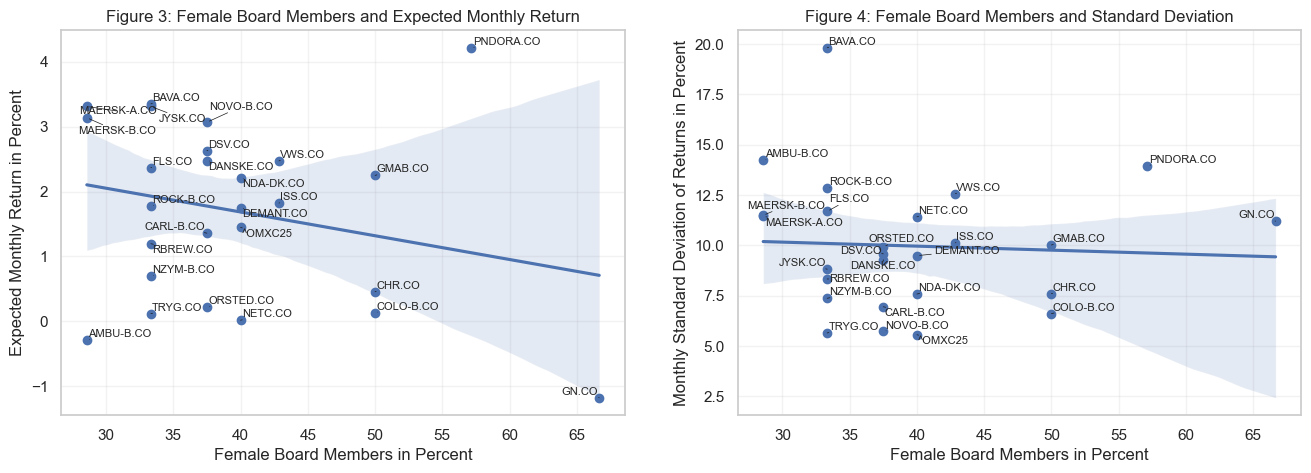

In [10]:
# create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Monthly return
x = fmr['femaleboard']
y1 = fmr['expectedmonthly']
label = fmr['yfinanceticker']
title1 = 'Figure 3: Female Board Members and Expected Monthly Return'
xlabel = 'Female Board Members in Percent'
ylabel1 = 'Expected Monthly Return in Percent'

dp.plot_scatter_with_labels(ax1, x, y1, label, title1, xlabel, ylabel1)

# Standard deviation
y2 = fmr['stdmonthly']
title2 = 'Figure 4: Female Board Members and Standard Deviation'
ylabel2 = 'Monthly Standard Deviation of Returns in Percent'

dp.plot_scatter_with_labels(ax2, x, y2, label, title2, xlabel, ylabel2)

# Show the plots
plt.show()

There doesn't seem to be a significant correlation in either plot. The presence of more women on the board does not appear to influence the average returns, as the confidence bands are quite wide, and the regression line is likely influenced by the outlier GN Store Nord. Similarly, the standard deviation plot shows no clear relationship between the proportion of women on the board and the monthly standard deviation. In other words, having more or fewer women on the board does not appear to affect the monthly standard deviation.

I create a portfolio weighted by the propertion of women on board of directors for each company.

In [11]:
# remove row with C25 index
wC25F = C25F.loc[C25F['company'] != 'OMX COPENHAGEN 25 INDEX']

# update Maersk A and B by dividing by 2
wC25F.loc[wC25F['yfinanceticker'].isin(['MAERSK-A.CO', 'MAERSK-B.CO']), 'femaleboard'] /= 2

# normalize femaleboard to 1
wC25F['femaleboard'] = dp.normalize_column(wC25F['femaleboard'])

# remove # to see portfolio weights
#wC25F.head() 

C:\Users\jonas\AppData\Local\Temp\ipykernel_15072\2970570788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wC25F['femaleboard'] = dp.normalize_column(wC25F['femaleboard'])


In [12]:
# sort values ascending to match w_hist_mr
wC25F = wC25F.sort_values('yfinanceticker', ascending=True)

# create list for weights
wC25F_list = wC25F['femaleboard'].values.tolist()

# remove column with C25 index
w_hist_mr = hist_mr.drop(columns = '^OMXC25')

# sort columns ascending to match wC25F
sorted_columns = sorted(w_hist_mr.columns)
w_hist_mr = w_hist_mr[sorted_columns]


In [13]:
# calculate portfolio returns
port_r, cum_port_r = dp.calculate_portfolio_returns(data = w_hist_mr, weights = wC25F_list)

# convert to dataframe
cum_port_r = cum_port_r.to_frame(name='^WOMXC25')

I create a plot of cumulative returns of each stock relative to the WC25 index.

In [14]:
# create new ticker list which includes ^WOMXC25
C26_tickers = C25_tickers + list(cum_port_r.columns)

# merge cum_port_ret to hist_cr
hist_cr = pd.merge(hist_cr, cum_port_r, left_index=True, right_index=True, how='outer')

# define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options=C26_tickers, description='Stock:')

# display the interactive plot using widgets interact
widgets.interact(dp.cum_ret_plot, data=widgets.fixed(hist_cr), stock=stockpicker,
                # set reference
                ref = widgets.fixed('^WOMXC25'),
                # set figure no.
                fig = widgets.fixed(5),
                # ax_data are only for non-interactive plots
                ax_data=widgets.fixed(None));

interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

When examining the portfolio that is weighted based on the proportion of female board members, it becomes evident that the return is marginally greater than that of the C25 index. One possible explanation for this difference could be the continuous weighting of the C25 index by each company's market value, capped at 15%. In the C25 index, the underperformance of larger companies has a significant impact, whereas in the gender-weighted portfolio, this effect is mitigated.

# Conclusion

The analysis does not provide definitive evidence regarding the impact of female board members on investor returns. While a portfolio weighted by the presence of women on boards demonstrates a slightly higher performance than the C25 index, this could be attributed to the composition methodology of the C25 index itself. It is plausible that other portfolios with more evenly distributed stock weights could also outperform the C25. As a result, there is no concrete proof that an increased number of women on the board of directors directly correlates to lower or higher investor returns within the C25 index.